# Setup, installs, imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install transformers -q

     |████████████████████████████████| 778kB 2.9MB/s 
     |████████████████████████████████| 890kB 14.1MB/s 
     |████████████████████████████████| 1.1MB 12.3MB/s 
     |████████████████████████████████| 3.0MB 25.6MB/s 


In [ ]:
import transformers
from google.colab import files
from transformers import BertTokenizer
import json
import pandas as pd
import numpy as np
import os
import pickle
import ast
from tqdm.autonotebook import tqdm
import babel.dates
import datetime
from __future__ import generators
import glob
import random
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from joblib import dump, load


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

# Helper functions and variables

In [ ]:
id2label = {
    0: 'O',
    1: 'Company',
    2: 'City',
    3: 'Code',
    4: 'Street',
    5: 'Date',
    6: 'Period',
    7: 'Person',
    8: 'Role'
}

In [ ]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [ ]:
def convert_date(str0):

  dt = datetime.datetime.strptime(str0, '%Y-%m-%d')

  str1 = babel.dates.format_date(dt, 'd MMMM yyyy', locale='pl_PL')
  str2 = babel.dates.format_date(dt, 'd.M.Y', locale='pl_PL')
  str4 = babel.dates.format_date(dt, 'd. M. Y', locale='pl_PL')
  str5 = babel.dates.format_date(dt, 'd-M-Y', locale='pl_PL')
  str6 = babel.dates.format_date(dt, 'dd-MM-Y', locale='pl_PL')
  str7 = babel.dates.format_date(dt, 'dd.MM.Y', locale='pl_PL')

  i_to_month = {
      '1': 'styczeń',
      '2': 'luty',
      '3': 'marzec',
      '4': 'kwiecień',
      '5': 'maj',
      '6': 'czerwiec',
      '7': 'lipiec',
      '8': 'sierpień',
      '9': 'wrzesień',
      '10': 'październik',
      '11': 'listopad',
      '12': 'grudzień'
  }

  str3 = babel.dates.format_date(dt, 'd', locale='pl_PL') + ' ' + i_to_month[babel.dates.format_date(dt, 'M', locale='pl_PL')] + ' ' + babel.dates.format_date(dt, 'Y', locale='pl_PL')
  str8 = babel.dates.format_date(dt, 'd', locale='pl_PL') + ' ' + babel.dates.format_date(dt, 'MMMM', locale='pl_PL') + ', ' + babel.dates.format_date(dt, 'Y', locale='pl_PL')

  return (str0, str1, str2, str3, str4, str5, str6, str7, str8)

In [ ]:
def convert_period(period_from, period_to):
  res = []
  fr = datetime.datetime.strptime(period_from, '%Y-%m-%d')
  to = datetime.datetime.strptime(period_to, '%Y-%m-%d')
  year_fr = babel.dates.format_date(fr, 'Y', locale='pl_PL')
  year_to = babel.dates.format_date(to, 'Y', locale='pl_PL')
  dm_fr = babel.dates.format_date(fr, 'd.M', locale='pl_PL')
  dm_to = babel.dates.format_date(to, 'd.M', locale='pl_PL')

  if dm_fr == '1.1' and dm_to == '30.6':
    res.append(f'I półrocze {year_to}')
    res.append(f'I PÓŁROCZE {year_to}')
  if dm_fr == '1.7' and dm_to == '31.12':
    res.append(f'II półrocze {year_to}')
    res.append(f'II PÓŁROCZE {year_to}')
  froms = convert_date(period_from)
  tos = convert_date(period_to)

  for i in range(len(froms)):
    res.append(f'od {froms[i]} do {tos[i]}')
    res.append(f'{froms[i]} - {tos[i]}')

  return res

In [ ]:
# Knuth-Morris-Pratt string matching
# David Eppstein, UC Irvine, 1 Mar 2002

def KnuthMorrisPratt(text, pattern):

    '''Yields all starting positions of copies of the pattern in the text.
Calling conventions are similar to string.find, but its arguments can be
lists or iterators, not just strings, it returns all matches, not just
the first one, and it does not need the whole text in memory at once.
Whenever it yields, it will have read the text exactly up to and including
the match that caused the yield.'''

    # allow indexing into pattern and protect against change during yield
    pattern = list(pattern)

    # build table of shift amounts
    shifts = [1] * (len(pattern) + 1)
    shift = 1
    for pos in range(len(pattern)):
        while shift <= pos and pattern[pos] != pattern[pos-shift]:
            shift += shifts[pos-shift]
        shifts[pos+1] = shift

    # do the actual search
    startPos = 0
    matchLen = 0
    for c in text:
        while matchLen == len(pattern) or \
              matchLen >= 0 and pattern[matchLen] != c:
            startPos += shifts[matchLen]
            matchLen -= shifts[matchLen]
        matchLen += 1
        if matchLen == len(pattern):
            yield startPos

In [ ]:
def tokenize(path):
  doc_tokens = []
  with open(path, 'r') as f:
    for l in f.readlines():
      tkns = tokenizer.encode(l, add_special_tokens=False)
      doc_tokens.extend(tkns)
  return doc_tokens

def chunk(doc_tokens, max_seq_len=512, stride=128):
  max_seq_len = max_seq_len - 2 # [CLS], [SEP]
  examples = []
  start_index = 0
  end_index = max_seq_len
  while True:
    example = [101] + doc_tokens[start_index:end_index] + [102]
    examples.append(example)
    start_index += stride
    end_index += stride
    if end_index >= len(doc_tokens): break
  return examples

In [ ]:
def get_ners(df_row):
  d = { 'city': df_row.city,
        'code': df_row.postal_code,
        'company': df_row.company,
        'date': df_row.drawing_date,
        'period_from': df_row.period_from,
        'period_to': df_row.period_to,
        'street': df_row.street,
        'number': df_row.street_no,
        'people': []
  }
  people = ast.literal_eval(df_row.people)
  for p in people:
    d['people'].append({
        'person': p[1],
        'role': p[2]
    })
  return d

In [ ]:
def convert_dict(d, tokenizer):
  res = []
  res.append([1, tokenizer.encode(d['company'], add_special_tokens=False)])
  res.append([2, tokenizer.encode(d['city'], add_special_tokens=False)])
  res.append([3, tokenizer.encode(d['code'], add_special_tokens=False)])
  res.append([4, tokenizer.encode(d['street'], add_special_tokens=False)])
  res.append([4, tokenizer.encode((d['street'] + ' ' + d['number']), add_special_tokens=False)])
  for e in d['people']:
    res.append([7, tokenizer.encode(e['person'], add_special_tokens=False)])
    res.append([8, tokenizer.encode(e['role'], add_special_tokens=False)])
  for dt in convert_date(d['date']):
    res.append([5, tokenizer.encode(dt, add_special_tokens=False)])
  for period in convert_period(d['period_from'], d['period_to']):
    res.append([6, tokenizer.encode(period, add_special_tokens=False)])
  return np.vstack(res)


In [ ]:
def convert_chunk(t, tokenizer, tners):
  tgt = [0] * len(t)
  for n in tners:
    ner_tokens, ner_label = n[1], n[0]
    for start in KnuthMorrisPratt(t, ner_tokens):
      for i in range(len(ner_tokens)): tgt[start+i] = ner_label
  return tgt

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [ ]:
ignore_labels = ['O']

In [ ]:
def model_outputs_to_df(model_outputs, chunk_examples, chunk_ids, tokenizer):
    res = []

    for chunk in tqdm(range(len(chunk_ids))):

      cid = chunk_ids[chunk]
      tokens = chunk_examples[chunk]
      input_ids = tokens
      sentence = tokenizer.decode(tokens)
      outputs = model_outputs[chunk] # will this work? or [0,:,:]?
      scores = np.exp(outputs) / np.exp(outputs).sum(-1, keepdims=True)
      labels_idx = scores.argmax(axis=-1)

      results = []
      token_indices = []
      token_logits = []
      entity_type = None
      last_idx = -2
      last_label_idx = -1

      for idx, label_idx in enumerate(labels_idx):
        if id2label[label_idx] not in ignore_labels:
          if idx - 1 > last_idx or label_idx != last_label_idx:  # new entity
            if token_indices != []: # we need to add previous result to the list
              results.append({
                  'entity_type': entity_type,
                  'avg_logit': np.average(token_logits),
                  'text': tokenizer.decode(token_indices),
                  'token_indices': token_indices,
                  'token_logits': token_logits
                  })
              token_indices = []
              token_logits = []
            entity_type = id2label[label_idx]
            last_label_idx = label_idx
            token_indices.append(int(input_ids[idx]))
            token_logits.append(outputs[idx][label_idx].item())
            last_idx = idx

          elif idx - 1 == last_idx and label_idx == last_label_idx: # continue same entity
            last_idx = idx
            token_indices.append(int(input_ids[idx]))
            token_logits.append(outputs[idx][label_idx].item())
          
          else: raise Exception('I did not expect that value!')

      if token_indices != []: 
        results.append({
                  'entity_type': entity_type,
                  'avg_logit': np.average(token_logits),
                  'text': tokenizer.decode(token_indices),
                  'token_indices': token_indices,
                  'token_logits': token_logits
                  })

      result = [
                cid,
                sentence,
                results
      ]

      res.append(result)
    
    df_results = pd.DataFrame(res, columns=['cid', 'sentence', 'results'])
    print(f'Done processing {len(res)} chunks.')
    return df_results

In [ ]:
def add_gt(cid, df_valid):
  return {
    'company': df_valid['company'].loc[df_valid['id'] == cid].values[0],
    'drawing_date': df_valid['drawing_date'].loc[df_valid['id'] == cid].values[0],
    'period_from': df_valid['period_from'].loc[df_valid['id'] == cid].values[0],
    'period_to': df_valid['period_to'].loc[df_valid['id'] == cid].values[0],
    'postal_code': df_valid['postal_code'].loc[df_valid['id'] == cid].values[0],
    'city': df_valid['city'].loc[df_valid['id'] == cid].values[0],
    'street': df_valid['street'].loc[df_valid['id'] == cid].values[0],
    'street_no': df_valid['street_no'].loc[df_valid['id'] == cid].values[0],
    'people': df_valid['people'].loc[df_valid['id'] == cid].values[0]
    }

In [ ]:
m1_to_i = {
  'styczeń'       :   '1',
  'luty'          :   '2',
  'marzec'        :   '3',
  'kwiecień'      :   '4',
  'maj'           :   '5',
  'czerwiec'      :   '6',
  'lipiec'        :   '7',
  'sierpień'      :   '8',
  'wrzesień'      :   '9',
  'październik'  :  '10',
  'listopad'     :  '11',
  'grudzień'     :  '12'
}

m2_to_i = {
  'stycznia'       :   '1',
  'lutego'          :   '2',
  'marca'        :   '3',
  'kwietnia'      :   '4',
  'maja'           :   '5',
  'czerwca'      :   '6',
  'lipca'        :   '7',
  'sierpnia'      :   '8',
  'września'      :   '9',
  'października'  :  '10',
  'listopada'     :  '11',
  'grudnia'     :  '12'
}

In [ ]:
def date_format(date_string):
  # DATE_FORMATS = ['d MMMM yyyy', 'd.M.Y', 'd. M. Y', 'd-M-Y', 'dd-MM-Y', 'dd.MM.Y']
  unform = '[unparsed] ' + date_string
  if any(word in date_string for word in m2_to_i.keys()):
    elems = date_string.split()
    if len(elems) == 3:
      try: 
        day = int(elems[0])
        month = int(m2_to_i[elems[1]])
        year = int(elems[2])
        return datetime.datetime(year, month, day).strftime('%Y-%m-%d')
      except Exception as e:
        # print(str(e)) 
        return unform
    else: return unform
  if any(word in date_string for word in m1_to_i.keys()):
    elems = date_string.split()
    if len(elems) == 3:
      try: 
        day = int(elems[0])
        month = int(m1_to_i[elems[1]])
        year = int(elems[2])
        return datetime.datetime(year, month, day).strftime('%Y-%m-%d')
      except Exception as e:
        # print(str(e)) 
        return unform
    else: return unform

  try:
    date = babel.dates.parse_date(date_string, locale='pl_PL')
    return babel.dates.format_date(date, 'Y-MM-dd', locale='pl_PL')
  except Exception as e: 
    # print(str(e))
    pass

  return unform

In [ ]:
def period_format(period_string):
  period_from, period_to = None, None

  if ('II półrocze' or 'II PÓŁROCZE') in period_string:
    try:
      year = int(period_string.rsplit(' ', 1)[1])
      period_from = datetime.datetime(year, 7, 1).strftime('%Y-%m-%d')
      period_to = datetime.datetime(year, 12, 31).strftime('%Y-%m-%d')
      return period_from, period_to
    except:
      pass
  elif ('I półrocze' or 'I PÓŁROCZE') in period_string:
    try:
      year = int(period_string.rsplit(' ', 1)[1])
      period_from = datetime.datetime(year, 1, 1).strftime('%Y-%m-%d')
      period_to = datetime.datetime(year, 6, 30).strftime('%Y-%m-%d')
      return period_from, period_to
    except:
      pass

  if 'do' in period_string:
    try:
      period_string = period_string.replace('od', '')
      p1, p2 = period_string.rsplit('do', 1)
      period_from = date_format(p1)
      period_to = date_format(p2)
      return period_from, period_to
    except: 
      pass

  return period_from, period_to

In [ ]:
def city_pred(res):
  avg_logit = 0
  city = ''
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'City' and e['avg_logit'] > avg_logit:
      city = e['text']
      avg_logit = e['avg_logit']
  return city, avg_logit

def city_actual(gt):
  return ast.literal_eval(str(gt))['city']

def company_pred(res):
  avg_logit = 0
  company = ''
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'Company' and e['avg_logit'] > avg_logit:
      company = e['text']
      avg_logit = e['avg_logit']
  return company, avg_logit

def company_actual(gt):
  return ast.literal_eval(str(gt))['company']

def code_pred(res):
  avg_logit = 0
  code = ''
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'Code' and e['avg_logit'] > avg_logit:
      code = e['text'].replace(' ', '')
      avg_logit = e['avg_logit']
  return code, avg_logit

def code_actual(gt):
  return ast.literal_eval(str(gt))['postal_code']

def street_number_pred(res):
  avg_logit = 0
  street = ''
  number = ''
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'Street' and e['avg_logit'] > avg_logit:
      street_number = e['text']
      try: 
        street, number = street_number.rsplit(' ', 1)
      except:
        street = street_number
        number = ''
      avg_logit = e['avg_logit']
  return street, number, avg_logit

def street_actual(gt):
  return ast.literal_eval(str(gt))['street']

def number_actual(gt):
  return ast.literal_eval(str(gt))['street_no']

def date_pred(res):
  avg_logit = 0
  date = ''
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'Date' and e['avg_logit'] > avg_logit:
      date = e['text']
      # postprocess date
      avg_logit = e['avg_logit']
  return date, avg_logit

def date_actual(gt):
  return ast.literal_eval(str(gt))['drawing_date']

def period_pred(res):
  avg_logit = 0
  period = ''
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'Period' and e['avg_logit'] > avg_logit:
      period = e['text']
      avg_logit = e['avg_logit']
  return period, avg_logit

def period_from_actual(gt):
  return ast.literal_eval(str(gt))['period_from']

def period_to_actual(gt):
  return ast.literal_eval(str(gt))['period_to']

def person_pred(res):
  person = []
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'Person':
      person.append([e['text'], e['avg_logit']])
  return person

def role_pred(res):
  role = []
  res = ast.literal_eval(str(res))
  for e in res:
    if e['entity_type'] == 'Role':
      role.append([e['text'], e['avg_logit']])
  return role

def people_actual(gt):
  return ast.literal_eval(str(gt))['people']

In [ ]:
def people_format2(r):
  person_string, role_string, date_result = r[0], r[1], r[2]
  people = []
  pres = ast.literal_eval(str(person_string))
  rres = ast.literal_eval(str(role_string))
  for i in range(min(len(pres), len(rres))):
    people.append((str(date_result), pres[i][0], rres[i][0]))
  return people


def people_format(person_string, role_string, date_result):
  people = []
  pres = ast.literal_eval(str(person_string))
  rres = ast.literal_eval(str(role_string))
  for i in range(min(len(pres), len(rres))):
    people.append((str(date_result), pres[i][0], rres[i][0]))
  return people

In [ ]:
def people_score(row):
  acts = []
  pres = []
  act = ast.literal_eval(row[0])
  pre = ast.literal_eval(row[1])
  for x in act:
    acts.append(x[1])
    acts.append(x[2])
  for x in pre:
    pres.append(x[1])
    pres.append(x[2])

  union = [ x for x in pres if x in acts ]
  if len(acts) != 0: score = len(union) / len(acts)
  if len(acts) == 0: score = 0

  if score > 1: score = 1/score
  return score

In [ ]:
def normalize_company(txt):
  txt = txt.upper()
  txt = txt.replace('SPÓŁKA AKCYJNA', 'SA')
  txt = txt.replace('S.A.', 'SA')
  txt = txt.replace('S. A.', 'SA')
  txt = txt.replace('SPÓŁKI AKCYJNEJ', 'SA')
  txt = txt.replace('S. A', 'SA')
  txt = txt.replace('„', '')
  txt = txt.replace('”', '')
  txt = txt.replace(';', '')
  txt = txt.replace(',', '')
  return txt

# Data preprocessing

In [ ]:
!git clone git://gonito.net/poleval-financial-reports-pl

Cloning into 'poleval-financial-reports-pl'...
remote: Enumerating objects: 2768, done.
remote: Counting objects: 100% (2768/2768), done.
remote: Compressing objects: 100% (2753/2753), done.
remote: Total 2768 (delta 19), reused 2751 (delta 11), pack-reused 0
Receiving objects: 100% (2768/2768), 74.14 MiB | 15.66 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
# !wget http://poleval.pl/task4/task4-test.zip
# !unzip -q task4-test.zip

In [ ]:
# !wget http://poleval.pl/task4/task4-train.zip
# !wget http://poleval.pl/task4/task4-validate.zip

In [ ]:
# !unzip -q task4-train.zip
# !unzip -q task4-validate.zip

In [ ]:
# df_test = pd.DataFrame(os.listdir('reports'), columns=['id'])

In [ ]:
# df_train = pd.read_csv('ground_truth-train.csv', sep=';')

In [ ]:
# df_valid = pd.read_csv('ground_truth-validate.csv', sep=';')

In [ ]:
chunks_ners_test = []
for i in tqdm(range(len(df_test))):
  docid = df_test.loc[i].id
  path = 'reports/' + str(docid) + '/*.txt'
  filePaths = glob.glob(path)
  doc_tokens = tokenize(filePaths[0]) # just grab the first file, hoping there aren't any more
  chunks = chunk(doc_tokens)
  ners = None
  chunks_ners_test.append([chunks, ners, docid])

len(chunks_ners_test)

Token indices sequence length is longer than the specified maximum sequence length for this model (3740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1247 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3228 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2337 > 512). Running this sequence through the model will result in indexing errors


555

In [ ]:
chunks_ners_train = []
for i in tqdm(range(len(df_train))):
  docid = df_train.loc[i].id
  path = 'reports/' + str(docid) + '/*.txt'
  filePaths = glob.glob(path)
  doc_tokens = tokenize(filePaths[0]) # just grab the first file, hoping there aren't any more
  chunks = chunk(doc_tokens)
  ners = get_ners(df_train.loc[i])
  chunks_ners_train.append([chunks, ners, docid])

len(chunks_ners_train)

100%|██████████| 1662/1662 [17:04<00:00,  1.62it/s]


1662

In [ ]:
chunks_ners_valid = []
for i in tqdm(range(len(df_valid))):
  docid = df_valid.loc[i].id
  path = 'reports/' + str(docid) + '/*.txt'
  filePaths = glob.glob(path)
  doc_tokens = tokenize(filePaths[0]) # just grab the first file, hoping there aren't any more
  chunks = chunk(doc_tokens)
  ners = get_ners(df_valid.loc[i])
  chunks_ners_valid.append([chunks, ners, docid])

len(chunks_ners_valid)

 15%|█▍        | 82/554 [00:48<05:15,  1.50it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2117 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1774 > 512). Running this sequence through the model will result in indexing errors
 85%|████████▌ | 471/554 [04:51<01:47,  1.29s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (1051 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5386 > 512). Running this sequence through the model will result in index

554

In [ ]:
# l = [chunks_ners_train, chunks_ners_valid]
# with open('/content/drive/My Drive/poleval/chunkdata.pkl', 'wb') as fp:
#     pickle.dump(l, fp)

In [ ]:
# with open('/content/drive/My Drive/poleval/chunks_test_1.pkl', 'wb') as fp:
#     pickle.dump(chunks_ners_test, fp)

In [ ]:
train_examples = []
train_targets = []
train_ids = []

for cn in tqdm(chunks_ners_train):
  ners = convert_dict(cn[1], tokenizer)
  cid = cn[2]
  for e in cn[0]:    
    tgt = convert_chunk(e, tokenizer, ners)
    train_examples.append(e)
    train_targets.append(tgt)
    train_ids.append(cid)

assert(len(train_examples) == len(train_targets))
assert(len(train_examples) == len(train_ids))

len(train_examples)

100%|██████████| 1662/1662 [1:09:25<00:00,  2.51s/it]


642646

In [ ]:
test_examples = []
test_ids = []

for cn in tqdm(chunks_ners_test):
  cid = cn[2]
  for e in cn[0]:    
    test_examples.append(e)
    test_ids.append(cid)

assert(len(test_examples) == len(test_ids))

len(test_examples)

223626

In [ ]:
valid_examples = []
valid_targets = []
valid_ids = []

for cn in tqdm(chunks_ners_valid):
  ners = convert_dict(cn[1], tokenizer)
  cid = cn[2]
  for e in cn[0]:    
    tgt = convert_chunk(e, tokenizer, ners)
    valid_examples.append(e)
    valid_targets.append(tgt)
    valid_ids.append(cid)

assert(len(valid_examples) == len(valid_targets))
assert(len(valid_examples) == len(valid_ids))

len(valid_examples)

100%|██████████| 554/554 [22:40<00:00,  2.46s/it]


210215

In [ ]:
# l = [train_examples, train_targets, train_ids, valid_examples, valid_targets, valid_ids]
# with open('/content/drive/My Drive/poleval/data2.pkl', 'wb') as fp:
#     pickle.dump(l, fp)

In [ ]:
# l = [test_examples, test_ids]
# with open('/content/drive/My Drive/poleval/test_data_1.pkl', 'wb') as fp:
#     pickle.dump(l, fp)

# Load data

In [ ]:
with open('/content/drive/My Drive/poleval/data2.pkl', 'rb') as fp:
    [train_examples, train_targets, train_ids, valid_examples, valid_targets, valid_ids] = pickle.load(fp)

In [ ]:
len(train_examples)

642646

In [ ]:
train_ex_full = []
train_tgt_full = []
for i in range(len(train_examples)):
  if sum(train_targets[i]) > 0:
    train_ex_full.append(train_examples[i])
    train_tgt_full.append(train_targets[i])
len(train_ex_full)

206811

In [ ]:
train_examples, train_targets, train_ids = None, None, None

In [ ]:
valid_ex_full = []
valid_tgt_full = []
valid_ids_full = []
for i in range (len(valid_examples)):
  if sum([1 for x in valid_targets[i] if x != 0]) > 0:
    valid_ex_full.append(valid_examples[i])
    valid_tgt_full.append(valid_targets[i])
    valid_ids_full.append(valid_ids[i])
len(valid_ex_full)

67724

In [ ]:
random.seed(42)
idxs = random.sample(range(len(valid_ex_full)), 10000)
valid_examples_sample = [valid_ex_full[i] for i in idxs]
valid_targets_sample = [valid_tgt_full[i] for i in idxs]
valid_ids_sample = [valid_ids_full[i] for i in idxs]
len(valid_examples_sample)

10000

# Config

In [ ]:
pretrained_model = 'bert-base-multilingual-cased'
LR = 2e-5
WARMUP_STEPS = 10
MODEL_PATH = "model_ner_1.bin"

WINDOW_SIZE = 64
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 4
EPOCHS = 10

# Model

In [ ]:
class BERTForEntityExtraction(nn.Module):
    def __init__(self, bert_path):
        super(BERTForEntityExtraction, self).__init__()
        self.bert_path = bert_path
        self.bert = BertModel.from_pretrained(self.bert_path)
        self.bert_drop = nn.Dropout(0.3)
        self.ner_logits = nn.Linear(768, 9)

    def forward(self, ids, mask, token_type_ids):
        sequence_output, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        do = self.bert_drop(sequence_output)
        return self.ner_logits(do)

In [ ]:
# here I have fixed tokens len of 512, so I replace max_len with win_size
class BERTDatasetTraining:
    def __init__(self, tokens, targets, win_size):
        self.tokens = tokens
        self.win_size = win_size
        self.targets = targets

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, item):
        (ids, targets) = random_window(self.tokens[item], self.targets[item], win_size=self.win_size)
        token_type_ids = [1] * len(ids)
        mask = [0] * len(ids)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long) # should this be long or float?
        }

class BERTDatasetTest:
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, item):
        ids = self.tokens[item]
        token_type_ids = [1] * len(ids)
        mask = [0] * len(ids)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        }

def loss_fn(ner_outputs, ner_targets):
    ner_outputs = ner_outputs.permute(0,2,1)  
    return nn.CrossEntropyLoss()(ner_outputs, ner_targets) 

In [ ]:
def train_loop_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    losses = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader), mininterval=1.)

    for bi, d in enumerate(tk0):
        ids = d["ids"]
        mask = d["mask"]
        token_type_ids = d["token_type_ids"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        losses.update(loss.item(), ids.size(0))
        tk0.set_postfix(loss=losses.avg)

def eval_loop_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    fin_loss = []

    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader), mininterval=1.)
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            mask = d["mask"]
            token_type_ids = d["token_type_ids"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(outputs, targets)

            fin_targets.append(targets.cpu().detach().numpy())
            fin_outputs.append(outputs.cpu().detach().numpy())
            fin_loss.append(loss.cpu().detach().numpy())

    return np.concatenate(fin_outputs, axis=0), np.concatenate(fin_targets, axis=0), np.average(fin_loss)

def final_eval(data_loader, model, device):
    model.eval()
    fin_outputs = []

    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader), mininterval=1.)
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            mask = d["mask"]
            token_type_ids = d["token_type_ids"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            fin_outputs.append(outputs.cpu().detach().numpy())

    return np.concatenate(fin_outputs, axis=0)

In [ ]:
def run(train_tokens, train_targets, dev_tokens, dev_targets, pretrained_model):

    train_dataset = BERTDatasetTraining(
        tokens=train_tokens,   
        targets=train_targets,
        win_size=WINDOW_SIZE
    )
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )
    valid_dataset = BERTDatasetTraining(
        tokens=dev_tokens,
        targets=dev_targets,
        win_size=MAX_LEN
    )
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    device = 'cuda'
    num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
    model = BERTForEntityExtraction(pretrained_model).to(device)

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if (any(nd in n for nd in no_decay))], 'weight_decay': 0.0},
    ]
    optimizer = AdamW(optimizer_parameters, lr=LR)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=WARMUP_STEPS, 
        num_training_steps=num_train_steps
    )

    es = EarlyStopping(patience=5, mode="max")
    print(f"Training is Starting")

    for epoch in range(EPOCHS):
        train_loop_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
        o, targets, vloss = eval_loop_fn(valid_data_loader, model, device)
        predictions = np.argmax(o, axis=2)
        accuracy = np.average(predictions == targets)
        print(f"epoch = {epoch}, accuracy = {accuracy}, valid_loss = {vloss}")
        es(accuracy, model, model_path=MODEL_PATH)
        if es.early_stop:
            print("Early stopping")
            break
        

In [ ]:
def run_eval(test_tokens, model):

    model = model
    MAX_LEN = 512
    TEST_BATCH_SIZE = 4

    #debug
    # test_tokens = test_tokens[:64]

    test_dataset = BERTDatasetTest(
        tokens=test_tokens   
    )
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    device = 'cuda'
    outputs = final_eval(test_data_loader, model, device)

    return outputs
        

In [ ]:
def random_window(tokens, targets, pad=3, win_size=64):
  # need to consider adding pad as it was causing issues
  seq_len = len(tokens)
  if seq_len <= win_size: return (tokens, targets)
  # search for the first and last occurence of non-zero targets
  idxs = [i for i in range(seq_len) if targets[i] != 0]
  if idxs == []: # empty list
    start = random.randint(0, seq_len - win_size)
  else:
    start_index = idxs[0]
    end_index = idxs[-1]
    if end_index - start_index < win_size:
      start = min(max(random.randint(end_index - win_size, start_index), 0), seq_len-win_size)
    if end_index - start_index >= win_size:
      start = min(max(random.randint(start_index, end_index - win_size), 0), seq_len-win_size)
  win_tokens = tokens[start:start+win_size]
  win_targets = targets[start:start+win_size]
  win_tokens[0] = 101
  win_tokens[-1] = 102
  win_targets[0] = 0
  win_targets[-1] = 0
  assert(len(win_tokens) == len(win_targets))
  assert(len(win_tokens) == win_size)

  return (win_tokens, win_targets)

# Run model and postprocess

In [ ]:
run(train_ex_full, train_tgt_full, valid_examples_sample, valid_targets_sample, pretrained_model)


Training is Starting



epoch = 0, accuracy = 0.9956126953125, valid_loss = 0.013045000843703747
Validation score improved (-inf --> 0.9956126953125). Saving model!



epoch = 1, accuracy = 0.9958875, valid_loss = 0.013335861265659332
Validation score improved (0.9956126953125 --> 0.9958875). Saving model!



epoch = 2, accuracy = 0.995641015625, valid_loss = 0.01481109019368887
EarlyStopping counter: 1 out of 5



epoch = 3, accuracy = 0.995672265625, valid_loss = 0.015336227603256702
EarlyStopping counter: 2 out of 5



epoch = 4, accuracy = 0.9958423828125, valid_loss = 0.015010279603302479
EarlyStopping counter: 3 out of 5



epoch = 5, accuracy = 0.9960984375, valid_loss = 0.014394781552255154
Validation score improved (0.9958875 --> 0.9960984375). Saving model!



epoch = 6, accuracy = 0.9958953125, valid_loss = 0.016052495688199997
EarlyStopping counter: 1 out of 5



epoch = 7, accuracy = 0.996210546875, valid_loss = 0.015840742737054825
Validation score improved (0.9960984375 --> 0.996210546875). Saving model!



epoch = 8, accuracy = 0.9959693359375, valid_loss = 0.017191536724567413
EarlyStopping counter: 1 out of 5



epoch = 9, accuracy = 0.9960021484375, valid_loss = 0.017556093633174896
EarlyStopping counter: 2 out of 5


In [ ]:
!cp ./model_ner_1.bin /content/drive/My\ Drive/poleval/model_ner_2.bin

# Validation Eval

## Postprocessing

In [ ]:
model = BERTForEntityExtraction(pretrained_model)
model.load_state_dict(torch.load('/content/drive/My Drive/poleval/model_ner_2.bin'))
model.to('cuda')
model.eval();

In [ ]:
valid_outputs = run_eval(valid_examples, model)

In [ ]:
with open('/content/drive/My Drive/poleval/valid_outputs_model_ner_2.pkl', 'wb') as fp:
    pickle.dump(valid_outputs, fp)

In [ ]:
# with open('/content/drive/My Drive/poleval/valid_outputs_model_ner_2.pkl', 'rb') as fp:
#     valid_outputs = pickle.load(fp)

In [ ]:
df_valid = pd.read_csv('/content/drive/My Drive/poleval/ground_truth-validate.csv', sep=';')
df_results = model_outputs_to_df(valid_outputs, valid_examples, valid_ids, tokenizer)
df_results['gt'] = df_results['cid'].apply(lambda cid: add_gt(cid, df_valid))
df_results.to_csv('/content/drive/My Drive/poleval/model_ner_2_valid_res_allchunks.csv', index=False)


Done processing 210215 chunks.


In [ ]:
# df_results = pd.read_csv('/content/drive/My Drive/poleval/model_ner_1_valid_res_allchunks.csv')

In [ ]:
df_results = pd.read_csv('/content/drive/My Drive/poleval/results-fixed.csv')

In [ ]:
df_results['city_pred'], df_results['city_logits'] = zip(*df_results['results'].map(city_pred))
df_results['company_pred'], df_results['company_logits'] = zip(*df_results['results'].map(company_pred))
df_results['company_pred'] = df_results['company_pred'].apply(lambda t: normalize_company(t))
df_results['code_pred'], df_results['code_logits'] = zip(*df_results['results'].map(code_pred))
df_results['street_pred'], df_results['number_pred'], df_results['street_number_logits'] = zip(*df_results['results'].map(street_number_pred))
df_results['date_pred'], df_results['date_logits'] = zip(*df_results['results'].map(date_pred))
df_results['date_pred'] = df_results['date_pred'].apply(lambda r: date_format(r))
df_results['period_pred'], df_results['period_logits'] = zip(*df_results['results'].map(period_pred))
df_results['period_from_pred'], df_results['period_to_pred'] = zip(*df_results['period_pred'].map(period_format))
df_results['person_pred'] = df_results['results'].apply(lambda r: person_pred(r))
df_results['role_pred'] = df_results['results'].apply(lambda r: role_pred(r))
df_results['people_pred'] = df_results.apply(lambda r: people_format(r.person_pred, r.role_pred, r.date_pred), axis=1)

In [ ]:
df_results['city_act'] = df_results['gt'].apply(lambda r: city_actual(r))
df_results['city_match'] = (df_results['city_pred']==df_results['city_act']).astype(int)
df_results['company_act'] = df_results['gt'].apply(lambda r: company_actual(r))
df_results['company_act'] = df_results['company_act'].apply(lambda t: normalize_company(t))
df_results['company_match'] = (df_results['company_pred']==df_results['company_act']).astype(int)
df_results['code_act'] = df_results['gt'].apply(lambda r: code_actual(r))
df_results['code_match'] = (df_results['code_pred']==df_results['code_act']).astype(int)
df_results['number_act'] = df_results['gt'].apply(lambda r: number_actual(r))
df_results['street_act'] = df_results['gt'].apply(lambda r: street_actual(r))
df_results['number_match'] = (df_results['number_pred']==df_results['number_act']).astype(int)
df_results['street_match'] = (df_results['street_pred']==df_results['street_act']).astype(int)
df_results['date_act'] = df_results['gt'].apply(lambda r: date_actual(r))
df_results['date_match'] = (df_results['date_pred']==df_results['date_act']).astype(int)
df_results['period_from_act'] = df_results['gt'].apply(lambda r: period_from_actual(r))
df_results['period_to_act'] = df_results['gt'].apply(lambda r: period_to_actual(r))
df_results['period_from_match'] = (df_results['period_from_pred']==df_results['period_from_act']).astype(int)
df_results['period_to_match'] = (df_results['period_to_pred']==df_results['period_to_act']).astype(int)
df_results['people_act'] = df_results['gt'].apply(lambda r: people_actual(r))
df_results['people_match'] = (df_results['people_pred']==df_results['people_act']).astype(int)

In [ ]:
df_results.to_csv('/content/drive/My Drive/poleval/model_ner_orig_res_allchunks_pp.csv', index=False)
df_results.head()

,cid,sentence,results,gt,city_pred,city_logits,company_pred,company_logits,code_pred,code_logits,street_pred,number_pred,street_number_logits,date_pred,date_logits,period_pred,period_logits,period_from_pred,period_to_pred,person_pred,role_pred,people_pred,city_act,city_match,company_act,company_match,code_act,code_match,number_act,street_act,number_match,street_match,date_act,date_match,period_from_act,period_to_act,period_from_match,period_to_match,people_act,people_match
0,118820,[CLS] Raport półroczny PS - 2009 Półroczne sko...,"[{'entity_type': 'City', 'avg_logit': 9.479804...","{'company': 'APATOR SA', 'drawing_date': '2009...",Toruń,9.479805,,0.0,,0.0,,,0.0,[unparsed] 2009 - 08 - 24,6.501159,,0.0,None,None,[],[],[],Toruń,1,APATOR SA,0,87-100,0,21/29,ul. Żółkiewskiego,0,0,2009-08-31,0,2009-01-01,2009-06-30,0,0,"[('2009-08-31', 'Janusz Niedźwiecki', 'Prezes ...",0
1,118820,[CLS]............................................,[],"{'company': 'APATOR SA', 'drawing_date': '2009...",,0.000000,,0.0,,0.0,,,0.0,[unparsed],0.000000,,0.0,None,None,[],[],[],Toruń,0,APATOR SA,0,87-100,0,21/29,ul. Żółkiewskiego,0,0,2009-08-31,0,2009-01-01,2009-06-30,0,0,"[('2009-08-31', 'Janusz Niedźwiecki', 'Prezes ...",0
2,118820,[CLS]............................................,[],"{'company': 'APATOR SA', 'drawing_date': '2009...",,0.000000,,0.0,,0.0,,,0.0,[unparsed],0.000000,,0.0,None,None,[],[],[],Toruń,0,APATOR SA,0,87-100,0,21/29,ul. Żółkiewskiego,0,0,2009-08-31,0,2009-01-01,2009-06-30,0,0,"[('2009-08-31', 'Janusz Niedźwiecki', 'Prezes ...",0
3,118820,[CLS]............................................,[],"{'company': 'APATOR SA', 'drawing_date': '2009...",,0.000000,,0.0,,0.0,,,0.0,[unparsed],0.000000,,0.0,None,None,[],[],[],Toruń,0,APATOR SA,0,87-100,0,21/29,ul. Żółkiewskiego,0,0,2009-08-31,0,2009-01-01,2009-06-30,0,0,"[('2009-08-31', 'Janusz Niedźwiecki', 'Prezes ...",0
4,118820,[CLS]...................... 5 Skład Zarządu i ...,[],"{'company': 'APATOR SA', 'drawing_date': '2009...",,0.000000,,0.0,,0.0,,,0.0,[unparsed],0.000000,,0.0,None,None,[],[],[],Toruń,0,APATOR SA,0,87-100,0,21/29,ul. Żółkiewskiego,0,0,2009-08-31,0,2009-01-01,2009-06-30,0,0,"[('2009-08-31', 'Janusz Niedźwiecki', 'Prezes ...",0


## Chunk selection

In [ ]:
df_chunks = pd.read_csv('/content/drive/My Drive/poleval/model_ner_orig_res_allchunks_pp.csv')

OOB Score: 0.9745529864310775
Feature ranking:
1. feature 6 : city_logits (0.378682)
2. feature 7 : company_logits (0.335524)
3. feature 0 : code_logits (0.129719)
4. feature 2 : street_number_logits (0.042789)
5. feature 3 : date_logits (0.042211)
6. feature 5 : period_logits (0.029777)
7. feature 4 : num_chunks (0.029514)
8. feature 1 : avg_logits (0.011785)


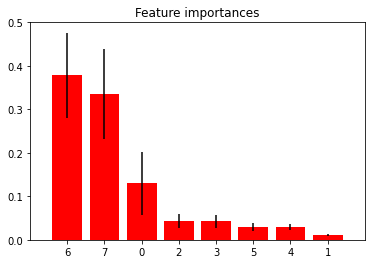

Total: 554, matches: 496, accuracy: 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,city_pred,city_proba,city_match
0,118820,Toruń,-0.116487,1
560,366876,Chojnice,0.000057,1
1362,175077,Warszawa,-1.469624,0
1489,208309,Gliwice,0.000097,1
1860,394366,Pianowo,0.000092,1


In [ ]:
#dfc: df chunks city
dfc = df_chunks[['cid', 'city_pred', 'city_logits', 'city_match', 'company_logits', 'code_logits', 'street_number_logits', 'date_logits', 'period_logits']]
dfc['num_chunks'] = dfc.groupby(['cid','city_pred'])['city_pred'].transform('count')
dfc['avg_logits'] = dfc.groupby(['cid','city_pred'])['city_logits'].transform('mean')
dfc.fillna(0, inplace=True)
y = dfc['city_match'][dfc['city_pred'] != 0]
X = dfc.drop(['cid', 'city_pred', 'city_match'], axis=1)[dfc['city_pred'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfc['city_proba'] = -1000.
dfc['city_proba'][dfc['city_pred'] != 0] = log_proba[:,1]
dfc['city_proba'] = dfc['city_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfc.groupby(['cid'])['city_proba'].transform(max) == dfc['city_proba']
df_city = dfc[['cid','city_pred', 'city_proba', 'city_match']][idx_max].copy()
total = len(df_city)
matches = df_city.city_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
city_acc = matches/total
df_city.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-city-ner2.joblib')

['/content/drive/My Drive/poleval/clf-city-ner2.joblib']

OOB Score: 0.7941475539487064
Feature ranking:
1. feature 0 : company_logits (0.939474)
2. feature 1 : city_logits (0.046500)
3. feature 2 : code_logits (0.014025)


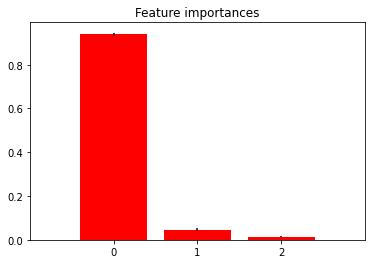

Total: 554, matches: 128, accuracy: 0.23


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,company_pred,company_proba,company_match
448,118820,APATOR SA,0.000097,1
1041,366876,ELEKTROMONT SA,-0.967570,0
1419,175077,DCG SA,-0.798418,0
1727,208309,BRE BANK SA,-1.139409,0
1878,394366,0,-999.999900,0


In [ ]:
#dfco: df chunks company
dfco = df_chunks[['cid', 'company_pred', 'company_logits', 'company_match', 'city_logits', 'code_logits']]
dfco.fillna(0, inplace=True)
y = dfco['company_match'][dfco['company_pred'] != 0]
X = dfco.drop(['cid', 'company_pred', 'company_match'], axis=1)[dfco['company_pred'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfco['company_proba'] = -1000.
dfco['company_proba'][dfco['company_pred'] != 0] = log_proba[:,1]
dfco['company_proba'] = dfco['company_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfco.groupby(['cid'])['company_proba'].transform(max) == dfco['company_proba']
df_company = dfco[['cid','company_pred', 'company_proba', 'company_match']][idx_max].copy()
total = len(df_company)
matches = df_company.company_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
company_acc = matches/total
df_company.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-company-ner2.joblib')

['/content/drive/My Drive/poleval/clf-company-ner2.joblib']

OOB Score: 0.9176935596372936
Feature ranking:
1. feature 0 : street_number_logits (0.458404)
2. feature 4 : company_logits (0.260058)
3. feature 2 : code_logits (0.143428)
4. feature 3 : city_logits (0.125841)
5. feature 1 : num_chunks (0.012268)


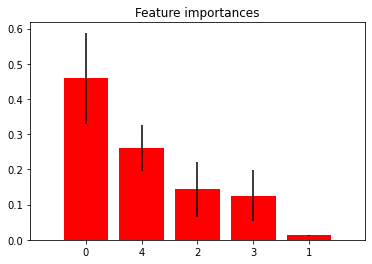

Total: 554, matches: 350, accuracy: 0.63


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,street_pred,street_proba,street_match
112,118820,[UNK],-2.659250,0
562,366876,Przemysłowa,-0.040803,1
1158,175077,Starowiślna,-0.020104,1
1475,208309,Górnych Wałów,-1.386211,0
1859,394366,Kwiatowa,0.000097,1


In [ ]:
#dfs: df chunks street
dfs = df_chunks[['cid', 'street_pred', 'street_number_logits', 'street_match', 'company_logits', 'code_logits', 'city_logits']]
dfs['num_chunks'] = dfs.groupby(['cid','street_pred'])['street_pred'].transform('count')
dfs.fillna(0, inplace=True)
y = dfs['street_match'][dfs['street_pred'] != 0]
X = dfs.drop(['cid', 'street_pred', 'street_match'], axis=1)[dfs['street_pred'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfs['street_proba'] = -1000.
dfs['street_proba'][dfs['street_pred'] != 0] = log_proba[:,1]
dfs['street_proba'] = dfs['street_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfs.groupby(['cid'])['street_proba'].transform(max) == dfs['street_proba']
df_street = dfs[['cid','street_pred', 'street_proba', 'street_match']][idx_max].copy()
total = len(df_street)
matches = df_street.street_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
street_acc = matches/total
df_street.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-street-ner2.joblib')

['/content/drive/My Drive/poleval/clf-street-ner2.joblib']

OOB Score: 0.9014334470989761
Feature ranking:
1. feature 4 : street_number_logits (0.398484)
2. feature 0 : company_logits (0.313925)
3. feature 3 : code_logits (0.143469)
4. feature 2 : city_logits (0.125274)
5. feature 1 : num_chunks (0.018847)


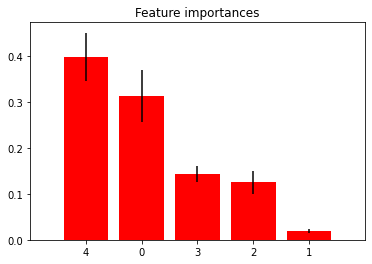

Total: 554, matches: 374, accuracy: 0.68


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,number_pred,number_proba,number_match
24,118820,0,-999.999900,0
560,366876,15,-0.009981,1
1157,175077,48,-0.030407,1
1680,208309,42,-0.020201,1
1858,394366,2,0.000093,1


In [ ]:
#dfn: df chunks number
dfs = df_chunks[['cid', 'number_pred', 'street_number_logits', 'number_match', 'company_logits', 'code_logits', 'city_logits']]
dfs['num_chunks'] = dfs.groupby(['cid','number_pred'])['number_pred'].transform('count')
dfs.fillna(0, inplace=True)
y = dfs['number_match'][dfs['number_pred'] != 0]
X = dfs.drop(['cid', 'number_pred', 'number_match'], axis=1)[dfs['number_pred'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfs['number_proba'] = -1000.
dfs['number_proba'][dfs['number_pred'] != 0] = log_proba[:,1]
dfs['number_proba'] = dfs['number_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfs.groupby(['cid'])['number_proba'].transform(max) == dfs['number_proba']
df_number = dfs[['cid','number_pred', 'number_proba', 'number_match']][idx_max].copy()
total = len(df_number)
matches = df_number.number_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
number_acc = matches/total
df_number.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-number-ner2.joblib')

['/content/drive/My Drive/poleval/clf-number-ner2.joblib']

OOB Score: 0.9301380991064175
Feature ranking:
1. feature 4 : code_logits (0.363140)
2. feature 0 : company_logits (0.328601)
3. feature 2 : street_number_logits (0.146868)
4. feature 3 : city_logits (0.141568)
5. feature 1 : num_chunks (0.019823)


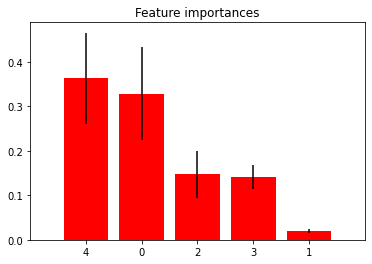

Total: 554, matches: 390, accuracy: 0.7


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,code_pred,code_proba,code_match
85,118820,0,-999.999900,0
564,366876,89-600,0.000036,1
1156,175077,31-035,0.000073,1
1473,208309,44-100,0.000080,1
1872,394366,64-000,0.000096,1


In [ ]:
#dfcd: df chunks code
dfcd = df_chunks[['cid', 'code_pred', 'code_logits', 'code_match', 'company_logits', 'street_number_logits', 'city_logits']]
dfcd['num_chunks'] = dfcd.groupby(['cid','code_pred'])['code_pred'].transform('count')
dfcd.fillna(0, inplace=True)
y = dfcd['code_match'][dfcd['code_pred'] != 0]
X = dfcd.drop(['cid', 'code_pred', 'code_match'], axis=1)[dfcd['code_pred'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfcd['code_proba'] = -1000.
dfcd['code_proba'][dfcd['code_pred'] != 0] = log_proba[:,1]
dfcd['code_proba'] = dfcd['code_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfcd.groupby(['cid'])['code_proba'].transform(max) == dfcd['code_proba']
df_code = dfcd[['cid','code_pred', 'code_proba', 'code_match']][idx_max].copy()
total = len(df_code)
matches = df_code.code_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
code_acc = matches/total
df_code.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-code-ner2.joblib')

['/content/drive/My Drive/poleval/clf-code-ner2.joblib']

OOB Score: 0.8659335776963234
Feature ranking:
1. feature 6 : date_logits (0.468979)
2. feature 0 : company_logits (0.318468)
3. feature 4 : code_logits (0.107399)
4. feature 5 : street_number_logits (0.077437)
5. feature 3 : city_logits (0.011049)
6. feature 1 : period_logits (0.010986)
7. feature 2 : num_chunks (0.005683)


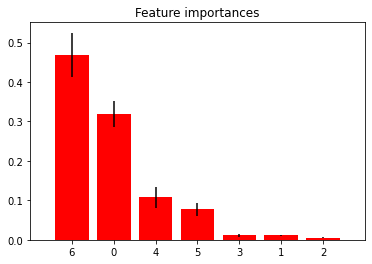

Total: 554, matches: 318, accuracy: 0.57


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,date_pred,date_proba,date_match
0,118820,[unparsed] 2009 - 08 - 24,-4.604930,0
712,366876,2017-09-29,0.000940,1
1193,175077,2011-08-31,-0.030178,1
1760,208309,2012-08-24,-1.108444,0
1813,394366,2018-08-13,-0.150021,1


In [ ]:
#dfd: df chunks date
dfd = df_chunks[['cid', 'date_pred', 'date_logits', 'date_match', 'company_logits', 'code_logits', 'street_number_logits', 'city_logits', 'period_logits']]
dfd['num_chunks'] = dfd.groupby(['cid','date_pred'])['date_pred'].transform('count')
dfd.fillna(0, inplace=True)
y = dfd['date_match'][dfd['date_logits'] != 0]
X = dfd.drop(['cid', 'date_pred', 'date_match'], axis=1)[dfd['date_logits'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfd['date_proba'] = -1000.
dfd['date_proba'][dfd['date_logits'] != 0] = log_proba[:,1]
dfd['date_proba'] = dfd['date_proba'].apply(lambda x: x+random.uniform(0, 0.001))
idx_max = dfd.groupby(['cid'])['date_proba'].transform(max) == dfd['date_proba']
df_date = dfd[['cid','date_pred', 'date_proba', 'date_match']][idx_max].copy()
total = len(df_date)
matches = df_date.date_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
date_acc = matches/total
df_date.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-date-ner2.joblib')

['/content/drive/My Drive/poleval/clf-date-ner2.joblib']

OOB Score: 0.7484609878310666
Feature ranking:
1. feature 0 : period_logits (0.984582)
2. feature 1 : company_logits (0.015418)


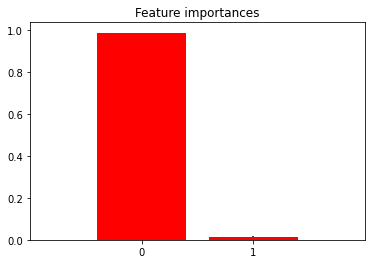

Total: 554, matches: 432, accuracy: 0.78


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,period_from_pred,period_from_proba,period_from_match
346,118820,2009-01-01,0.000994,1
644,366876,2017-01-01,0.000865,1
1177,175077,2011-01-01,0.000996,1
1672,208309,2012-01-01,0.000945,1
1976,394366,0,-999.999001,0


In [ ]:
#dfpf: df chunks period from
dfpf = df_chunks[['cid', 'period_from_pred', 'period_logits', 'period_from_match', 'company_logits']]
dfpf.fillna(0, inplace=True)
y = dfpf['period_from_match'][dfpf['period_logits'] != 0]
X = dfpf.drop(['cid', 'period_from_pred', 'period_from_match'], axis=1)[dfpf['period_logits'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfpf['period_from_proba'] = -1000.
dfpf['period_from_proba'][dfpf['period_logits'] != 0] = log_proba[:,1]
dfpf['period_from_proba'] = dfpf['period_from_proba'].apply(lambda x: x+random.uniform(0, 0.001))
idx_max = dfpf.groupby(['cid'])['period_from_proba'].transform(max) == dfpf['period_from_proba']
df_period_from = dfpf[['cid','period_from_pred', 'period_from_proba', 'period_from_match']][idx_max].copy()
total = len(df_period_from)
matches = df_period_from.period_from_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
period_from_acc = matches/total
df_period_from.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-periodfrom-ner2.joblib')

['/content/drive/My Drive/poleval/clf-periodfrom-ner2.joblib']

OOB Score: 0.7589835361488905
Feature ranking:
1. feature 0 : period_logits (0.985018)
2. feature 1 : company_logits (0.014982)


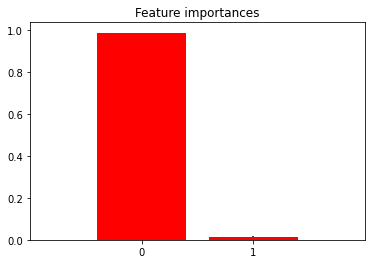

Total: 554, matches: 438, accuracy: 0.79


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,period_to_pred,period_to_proba,period_to_match
513,118820,2009-06-30,0.000984,1
642,366876,2017-06-30,0.000927,1
1169,175077,2011-06-30,0.000923,1
1505,208309,2012-06-30,0.000912,1
1880,394366,0,-999.999020,0


In [ ]:
#dfpt: df chunks period to
dfpt = df_chunks[['cid', 'period_to_pred', 'period_logits', 'period_to_match', 'company_logits']]
dfpt.fillna(0, inplace=True)
y = dfpt['period_to_match'][dfpt['period_logits'] != 0]
X = dfpt.drop(['cid', 'period_to_pred', 'period_to_match'], axis=1)[dfpt['period_logits'] != 0]
clf = RandomForestClassifier(oob_score=True)
clf.fit(X, y)
print(f'OOB Score: {clf.oob_score_}')
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
log_proba = clf.predict_log_proba(X)
dfpt['period_to_proba'] = -1000.
dfpt['period_to_proba'][dfpt['period_logits'] != 0] = log_proba[:,1]
dfpt['period_to_proba'] = dfpt['period_to_proba'].apply(lambda x: x+random.uniform(0, 0.001))
idx_max = dfpt.groupby(['cid'])['period_to_proba'].transform(max) == dfpt['period_to_proba']
df_period_to = dfpt[['cid','period_to_pred', 'period_to_proba', 'period_to_match']][idx_max].copy()
total = len(df_period_to)
matches = df_period_to.period_to_match.sum()
print(f'Total: {total}, matches: {matches}, accuracy: {round(matches/total, 2)}')
period_to_acc = matches/total
df_period_to.head()

In [ ]:
dump(clf, '/content/drive/My Drive/poleval/clf-periodto-ner2.joblib')

['/content/drive/My Drive/poleval/clf-periodto-ner2.joblib']

### People

OOB Score: 0.11506425004644372
Feature ranking:
1. feature 0 : city_logits (0.269595)
2. feature 4 : company_logits (0.267716)
3. feature 3 : date_logits (0.256919)
4. feature 2 : period_logits (0.176548)
5. feature 1 : len_pred (0.029221)


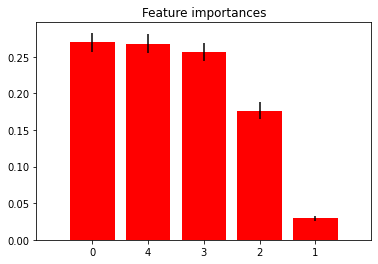

Total: 554, mean score: 0.7330744575015493


,cid,date_pred,people_pred,pred_score,score,people_corr
0,118820,[unparsed] 2009 - 08 - 24,"[('[unparsed] ', 'Janusz Niedźwiecki', 'Prezes...",0.776714,0.750000,"[('[unparsed] 2009 - 08 - 24 ', 'Janusz Niedźw..."
1,366876,2017-09-29,"[('2017-09-29', 'Marcin Garus', 'Prezes Zarząd...",0.493423,0.250000,"[('2017-09-29', 'Marcin Garus', 'Prezes Zarząd..."
2,175077,2011-08-31,"[('[unparsed] ', 'Grzegorz Pilch', '.'), ('[un...",0.460923,0.333333,"[('2011-08-31 ', 'Grzegorz Pilch', '.'), ('201..."
3,208309,2012-08-24,"[('[unparsed] ', 'Ewa Bobkowska', 'Prezes Zarz...",0.914056,1.000000,"[('2012-08-24 ', 'Ewa Bobkowska', 'Prezes Zarz..."
4,394366,2018-08-13,"[('[unparsed] ', 'Marek Dworczak', 'Prezes Zar...",0.827568,1.000000,"[('2018-08-13 ', 'Marek Dworczak', 'Prezes Zar..."


In [ ]:
#dfp: df chunks people
dfp = df_chunks[['cid', 'people_pred', 'people_act', 'city_logits', 'company_logits', 'date_logits', 'period_logits']]
dfp['len_pred'] = dfp['people_pred'].apply(lambda r: len(ast.literal_eval(r)))
dfp['score'] = dfp[['people_act', 'people_pred']].apply(people_score, axis=1)
dfp.fillna(0, inplace=True)
y = dfp['score'][dfp['score'] != 0]
X = dfp.drop(['cid', 'score', 'people_pred', 'people_act'], axis=1)[dfp['score'] != 0]
reg = RandomForestRegressor(oob_score=True)
reg.fit(X, y)
print(f'OOB Score: {reg.oob_score_}')
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
pred_score = reg.predict(X)
dfp['pred_score'] = -1.
dfp['pred_score'][dfp['score'] != 0] = pred_score
dfp['pred_score'] = dfp['pred_score'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfp.groupby(['cid'])['pred_score'].transform(max) == dfp['pred_score']
df_people = dfp[['cid', 'people_pred', 'pred_score', 'score']][idx_max].copy()
df_people_corr = pd.merge(df_date[['cid','date_pred']], df_people[['cid', 'people_pred', 'pred_score', 'score']], on='cid')
df_people_corr['people_corr'] = df_people_corr.apply(lambda t: str(t.people_pred).replace('[unparsed]', t.date_pred), axis=1)
total = len(df_people)
mean_score = df_people.score.mean()
print(f'Total: {total}, mean score: {mean_score}')
people_acc = mean_score
df_people_corr.head()

In [ ]:
dump(reg, '/content/drive/My Drive/poleval/reg-people-ner2.joblib')

['/content/drive/My Drive/poleval/reg-people-ner2.joblib']

In [ ]:
#TODO: remove duplicate tuples from people pred, eg:
#dfp.loc[1775][1]
#[('[unparsed] ', 'Ewa Bobkowska', 'Prezes Zarządu'), ('[unparsed] ', 'Stanisław Lessaer', 'Wiceprezes Zarządu'), ('[unparsed] ', 'Przemysław Żur', 'Wiceprezes Zarządu'), ('[unparsed] ', 'Jarosław Broda', 'Wiceprezes Zarządu'), ('[unparsed] ', 'Ewa Bobkowska', 'Prezes Zarządu'), ('[unparsed] ', 'Stanisław Lessaer', 'Wiceprezes Zarządu'), ('[unparsed] ', 'Przemysław Żur', 'Wiceprezes Zarządu'), ('[unparsed] ', 'Jarosław Broda', '##ceprezes Zarządu')]

In [ ]:
#TODO: join all scores here to track performance across experiments

# Test Inference

In [ ]:
valid_examples, valid_targets, valid_ids = None, None, None
df_chunks, df_results = None, None

In [ ]:
with open ('/content/drive/My Drive/poleval/test_data_1.pkl', 'rb') as fp:
    [test_examples, test_ids] = pickle.load(fp)

In [ ]:
test_outputs = run_eval(test_examples, model)

In [ ]:
with open('/content/drive/My Drive/poleval/test_outputs_model_ner_2.pkl', 'wb') as fp:
    pickle.dump(test_outputs, fp)

In [ ]:
df_results = model_outputs_to_df(test_outputs, test_examples, test_ids, tokenizer)
df_results.to_csv('/content/drive/My Drive/poleval/model_ner_2_test_res_allchunks.csv', index=False)


Done processing 223626 chunks.


In [ ]:
df_results = pd.read_csv('/content/drive/My Drive/poleval/ner1_test_res_allchunks.csv')

In [ ]:
df_results['city_pred'], df_results['city_logits'] = zip(*df_results['results'].map(city_pred))
df_results['company_pred'], df_results['company_logits'] = zip(*df_results['results'].map(company_pred))
df_results['company_pred'] = df_results['company_pred'].apply(lambda t: normalize_company(t))
df_results['code_pred'], df_results['code_logits'] = zip(*df_results['results'].map(code_pred))
df_results['street_pred'], df_results['number_pred'], df_results['street_number_logits'] = zip(*df_results['results'].map(street_number_pred))
df_results['date_pred'], df_results['date_logits'] = zip(*df_results['results'].map(date_pred))
df_results['date_pred'] = df_results['date_pred'].apply(lambda r: date_format(r))
df_results['period_pred'], df_results['period_logits'] = zip(*df_results['results'].map(period_pred))
df_results['period_from_pred'], df_results['period_to_pred'] = zip(*df_results['period_pred'].map(period_format))
df_results['person_pred'] = df_results['results'].apply(lambda r: person_pred(r))
df_results['role_pred'] = df_results['results'].apply(lambda r: role_pred(r))
df_results['people_pred'] = df_results.apply(lambda r: people_format(r.person_pred, r.role_pred, r.date_pred), axis=1)

In [ ]:
df_results.to_csv('/content/drive/My Drive/poleval/model_ner_orig_test_res_allchunks_pp.csv', index=False)

In [ ]:
df_chunks = pd.read_csv('/content/drive/My Drive/poleval/model_ner_orig_test_res_allchunks_pp.csv')

In [ ]:
# city
clf = load('/content/drive/My Drive/poleval/clf-city-ner2.joblib')
dfc = df_chunks[['cid', 'city_pred', 'city_logits', 'company_logits', 'code_logits', 'street_number_logits', 'date_logits', 'period_logits']]
dfc['num_chunks'] = dfc.groupby(['cid','city_pred'])['city_pred'].transform('count')
dfc['avg_logits'] = dfc.groupby(['cid','city_pred'])['city_logits'].transform('mean')
dfc.fillna(0, inplace=True)
X = dfc.drop(['cid', 'city_pred'], axis=1)[dfc['city_pred'] != 0]
log_proba = clf.predict_log_proba(X)
dfc['proba'] = -1000.
dfc['proba'][dfc['city_pred'] != 0] = log_proba[:,1]
dfc['proba'] = dfc['proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfc.groupby(['cid'])['proba'].transform(max) == dfc['proba']
df_city = dfc[['cid','city_pred']][idx_max].copy()
total = len(df_city)
print(f'Total: {total}')
df_city.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,city_pred
367,363426,Puławy
665,330815,Słupsk
989,143701,Kęty
1359,395486,Wronki
1489,365957,Włoszczowa


In [ ]:
#company
clf = load('/content/drive/My Drive/poleval/clf-company-ner2.joblib')
dfco = df_chunks[['cid', 'company_pred', 'company_logits', 'city_logits', 'code_logits']]
dfco.fillna(0, inplace=True)
X = dfco.drop(['cid', 'company_pred'], axis=1)[dfco['company_pred'] != 0]
log_proba = clf.predict_log_proba(X)
dfco['company_proba'] = -1000.
dfco['company_proba'][dfco['company_pred'] != 0] = log_proba[:,1]
dfco['company_proba'] = dfco['company_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfco.groupby(['cid'])['company_proba'].transform(max) == dfco['company_proba']
df_company = dfco[['cid','company_pred', 'company_proba']][idx_max].copy()
total = len(df_company)
print(f'Total: {total}')
df_company.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,company_pred,company_proba
600,363426,0,-999.999900
649,330815,0,-999.999901
802,143701,0,-999.999900
1372,395486,AMICA SA,-0.579755
1720,365957,ZPUE SA,0.000099


In [ ]:
#street
clf = load('/content/drive/My Drive/poleval/clf-street-ner2.joblib')
dfs = df_chunks[['cid', 'street_pred', 'street_number_logits', 'company_logits', 'code_logits', 'city_logits']]
dfs['num_chunks'] = dfs.groupby(['cid','street_pred'])['street_pred'].transform('count')
dfs.fillna(0, inplace=True)
X = dfs.drop(['cid', 'street_pred'], axis=1)[dfs['street_pred'] != 0]
log_proba = clf.predict_log_proba(X)
dfs['street_proba'] = -1000.
dfs['street_proba'][dfs['street_pred'] != 0] = log_proba[:,1]
dfs['street_proba'] = dfs['street_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfs.groupby(['cid'])['street_proba'].transform(max) == dfs['street_proba']
df_street = dfs[['cid','street_pred', 'street_proba']][idx_max].copy()
total = len(df_street)
print(f'Total: {total}')
df_street.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,street_pred,street_proba
129,363426,Al. Tysiąclecia Państwa Polskiego,-0.562113
666,330815,Owocowa,-0.020149
1023,143701,Kościuszki,-0.385563
1120,395486,ul. Mickiewicza,-2.040208
1487,365957,Jędrzejowska,-0.356619


In [ ]:
#number
clf = load('/content/drive/My Drive/poleval/clf-number-ner2.joblib')
dfs = df_chunks[['cid', 'number_pred', 'street_number_logits', 'company_logits', 'code_logits', 'city_logits']]
dfs['num_chunks'] = dfs.groupby(['cid','number_pred'])['number_pred'].transform('count')
dfs.fillna(0, inplace=True)
X = dfs.drop(['cid', 'number_pred'], axis=1)[dfs['number_pred'] != 0]
log_proba = clf.predict_log_proba(X)
dfs['number_proba'] = -1000.
dfs['number_proba'][dfs['number_pred'] != 0] = log_proba[:,1]
dfs['number_proba'] = dfs['number_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfs.groupby(['cid'])['number_proba'].transform(max) == dfs['number_proba']
df_number = dfs[['cid','number_pred', 'number_proba']][idx_max].copy()
total = len(df_number)
print(f'Total: {total}')
df_number.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,number_pred,number_proba
129,363426,13,-0.415461
666,330815,24,-0.010042
883,143701,111,-0.186243
1111,395486,52,-1.771889
1489,365957,79c,-0.010005


In [ ]:
#code 
clf = load('/content/drive/My Drive/poleval/clf-code-ner2.joblib')
dfcd = df_chunks[['cid', 'code_pred', 'code_logits', 'company_logits', 'street_number_logits', 'city_logits']]
dfcd['num_chunks'] = dfcd.groupby(['cid','code_pred'])['code_pred'].transform('count')
dfcd.fillna(0, inplace=True)
X = dfcd.drop(['cid', 'code_pred'], axis=1)[dfcd['code_pred'] != 0]
log_proba = clf.predict_log_proba(X)
dfcd['code_proba'] = -1000.
dfcd['code_proba'][dfcd['code_pred'] != 0] = log_proba[:,1]
dfcd['code_proba'] = dfcd['code_proba'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfcd.groupby(['cid'])['code_proba'].transform(max) == dfcd['code_proba']
df_code = dfcd[['cid','code_pred', 'code_proba']][idx_max].copy()
total = len(df_code)
print(f'Total: {total}')
df_code.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,code_pred,code_proba
598,363426,0,-999.999900
667,330815,76-200,0.000079
827,143701,0,-999.999900
1116,395486,61-131,0.000089
1489,365957,29-100,-0.030414


In [ ]:
#date
clf = load('/content/drive/My Drive/poleval/clf-date-ner2.joblib')
dfd = df_chunks[['cid', 'date_pred', 'date_logits', 'company_logits', 'code_logits', 'street_number_logits', 'city_logits', 'period_logits']]
dfd['num_chunks'] = dfd.groupby(['cid','date_pred'])['date_pred'].transform('count')
dfd.fillna(0, inplace=True)
X = dfd.drop(['cid', 'date_pred'], axis=1)[dfd['date_logits'] != 0]
log_proba = clf.predict_log_proba(X)
dfd['date_proba'] = -1000.
dfd['date_proba'][dfd['date_logits'] != 0] = log_proba[:,1]
dfd['date_proba'] = dfd['date_proba'].apply(lambda x: x+random.uniform(0, 0.001))
idx_max = dfd.groupby(['cid'])['date_proba'].transform(max) == dfd['date_proba']
df_date = dfd[['cid','date_pred', 'date_proba']][idx_max].copy()
total = len(df_date)
print(f'Total: {total}')
df_date.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,date_pred,date_proba
153,363426,2017-08-22,-0.328145
733,330815,2016-08-30,-0.094235
867,143701,2010-08-12,0.000758
1167,395486,2018-08-30,-0.072098
1652,365957,2017-09-15,-0.370795


In [ ]:
#period_from
clf = load('/content/drive/My Drive/poleval/clf-periodfrom-ner2.joblib')
dfpf = df_chunks[['cid', 'period_from_pred', 'period_logits', 'company_logits']]
dfpf.fillna(0, inplace=True)
X = dfpf.drop(['cid', 'period_from_pred'], axis=1)[dfpf['period_logits'] != 0]
log_proba = clf.predict_log_proba(X)
dfpf['period_from_proba'] = -1000.
dfpf['period_from_proba'][dfpf['period_logits'] != 0] = log_proba[:,1]
dfpf['period_from_proba'] = dfpf['period_from_proba'].apply(lambda x: x+random.uniform(0, 0.001))
idx_max = dfpf.groupby(['cid'])['period_from_proba'].transform(max) == dfpf['period_from_proba']
df_period_from = dfpf[['cid','period_from_pred', 'period_from_proba']][idx_max].copy()
total = len(df_period_from)
print(f'Total: {total}')
df_period_from.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,period_from_pred,period_from_proba
41,363426,2017-01-01,0.000730
746,330815,2016-01-01,0.000969
996,143701,2009-01-01,0.000856
1412,395486,2018-01-01,0.000986
1789,365957,2017-01-01,0.000980


In [ ]:
#period_to
clf = load('/content/drive/My Drive/poleval/clf-periodto-ner2.joblib')
dfpt = df_chunks[['cid', 'period_to_pred', 'period_logits', 'company_logits']]
dfpt.fillna(0, inplace=True)
X = dfpt.drop(['cid', 'period_to_pred'], axis=1)[dfpt['period_logits'] != 0]
log_proba = clf.predict_log_proba(X)
dfpt['period_to_proba'] = -1000.
dfpt['period_to_proba'][dfpt['period_logits'] != 0] = log_proba[:,1]
dfpt['period_to_proba'] = dfpt['period_to_proba'].apply(lambda x: x+random.uniform(0, 0.001))
idx_max = dfpt.groupby(['cid'])['period_to_proba'].transform(max) == dfpt['period_to_proba']
df_period_to = dfpt[['cid','period_to_pred', 'period_to_proba']][idx_max].copy()
total = len(df_period_to)
print(f'Total: {total}')
df_period_to.head()

Total: 555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,cid,period_to_pred,period_to_proba
41,363426,2017-06-30,0.000977
773,330815,2016-06-30,0.000953
999,143701,2010-06-30,0.000929
1410,395486,2018-06-30,0.000979
1739,365957,2017-06-30,0.000991


In [ ]:
#people
reg = load('/content/drive/My Drive/poleval/reg-people-ner2.joblib')
dfp = df_chunks[['cid', 'people_pred', 'city_logits', 'company_logits', 'date_logits', 'period_logits']]
dfp['len_pred'] = dfp['people_pred'].apply(lambda r: len(ast.literal_eval(r)))
dfp.fillna(0, inplace=True)
X = dfp.drop(['cid', 'people_pred'], axis=1)[dfp['people_pred'] != '[]']
pred_score = reg.predict(X)
dfp['pred_score'] = -10
dfp['pred_score'][dfp['people_pred'] != '[]'] = pred_score
dfp['pred_score'] = dfp['pred_score'].apply(lambda x: x+random.uniform(0, 0.0001))
idx_max = dfp.groupby(['cid'])['pred_score'].transform(max) == dfp['pred_score']
df_people = dfp[['cid', 'people_pred', 'pred_score']][idx_max].copy()
df_people_corr = pd.merge(df_date[['cid','date_pred']], df_people[['cid', 'people_pred', 'pred_score']], on='cid')
df_people_corr['people_corr'] = df_people_corr.apply(lambda t: str(t.people_pred).replace('[unparsed]', t.date_pred), axis=1)
total = len(df_people_corr)
print(f'Total: {total}')
df_people_corr.head()

Total: 555


,cid,date_pred,people_pred,pred_score,people_corr
0,363426,2017-08-22,"[('[unparsed] ', 'Jacek Janiszek', 'Prezes Zar...",0.000093,"[('2017-08-22 ', 'Jacek Janiszek', 'Prezes Zar..."
1,330815,2016-08-30,"[('[unparsed] ', 'Tomasz Malicki', 'Prezes Zar...",0.000095,"[('2016-08-30 ', 'Tomasz Malicki', 'Prezes Zar..."
2,143701,2010-08-12,"[('2010-08-12', 'Dariusz Mańko', 'Prezes Zarzą...",1.000053,"[('2010-08-12', 'Dariusz Mańko', 'Prezes Zarzą..."
3,395486,2018-08-30,"[('2018-08-31', 'Jacek Rutkowski', 'Prezes Zar...",0.000088,"[('2018-08-31', 'Jacek Rutkowski', 'Prezes Zar..."
4,365957,2017-09-15,"[('[unparsed] ', 'Andrzej Grzybek', 'Prezes Za...",0.000067,"[('2017-09-15 ', 'Andrzej Grzybek', 'Prezes Za..."


In [ ]:
df_final = pd.merge(df_company[['cid','company_pred']], df_city[['cid', 'city_pred']], on='cid')
df_final = df_final.merge(df_code[['cid','code_pred']], on='cid')
df_final = df_final.merge(df_street[['cid','street_pred']], on='cid')
df_final = df_final.merge(df_number[['cid','number_pred']], on='cid')
df_final = df_final.merge(df_date[['cid','date_pred']], on='cid')
df_final = df_final.merge(df_period_from[['cid','period_from_pred']], on='cid')
df_final = df_final.merge(df_period_to[['cid','period_to_pred']], on='cid')
df_final = df_final.merge(df_people_corr[['cid','people_corr']], on='cid')
df_final.head()

,cid,company_pred,city_pred,code_pred,street_pred,number_pred,date_pred,period_from_pred,period_to_pred,people_corr
0,363426,0,Puławy,0,Al. Tysiąclecia Państwa Polskiego,13,2017-08-22,2017-01-01,2017-06-30,"[('2017-08-22 ', 'Jacek Janiszek', 'Prezes Zar..."
1,330815,0,Słupsk,76-200,Owocowa,24,2016-08-30,2016-01-01,2016-06-30,"[('2016-08-30 ', 'Tomasz Malicki', 'Prezes Zar..."
2,143701,0,Kęty,0,Kościuszki,111,2010-08-12,2009-01-01,2010-06-30,"[('2010-08-12', 'Dariusz Mańko', 'Prezes Zarzą..."
3,395486,AMICA SA,Wronki,61-131,ul. Mickiewicza,52,2018-08-30,2018-01-01,2018-06-30,"[('2018-08-31', 'Jacek Rutkowski', 'Prezes Zar..."
4,365957,ZPUE SA,Włoszczowa,29-100,Jędrzejowska,79c,2017-09-15,2017-01-01,2017-06-30,"[('2017-09-15 ', 'Andrzej Grzybek', 'Prezes Za..."


In [ ]:
df_final_res = df_final.copy()
df_valid = pd.read_csv('/content/drive/My Drive/poleval/ground_truth-validate.csv', sep=';')
df_final_res = df_final_res[['cid', 'company_pred', 'date_pred', 'period_from_pred', 'period_to_pred', 'code_pred', 'city_pred', 'street_pred', 'number_pred', 'people_corr']] 
df_final_res.columns = df_valid.columns
df_final_res.head()

,id,company,drawing_date,period_from,period_to,postal_code,city,street,street_no,people
0,363426,0,2017-08-22,2017-01-01,2017-06-30,0,Puławy,Al. Tysiąclecia Państwa Polskiego,13,"[('2017-08-22 ', 'Jacek Janiszek', 'Prezes Zar..."
1,330815,0,2016-08-30,2016-01-01,2016-06-30,76-200,Słupsk,Owocowa,24,"[('2016-08-30 ', 'Tomasz Malicki', 'Prezes Zar..."
2,143701,0,2010-08-12,2009-01-01,2010-06-30,0,Kęty,Kościuszki,111,"[('2010-08-12', 'Dariusz Mańko', 'Prezes Zarzą..."
3,395486,AMICA SA,2018-08-30,2018-01-01,2018-06-30,61-131,Wronki,ul. Mickiewicza,52,"[('2018-08-31', 'Jacek Rutkowski', 'Prezes Zar..."
4,365957,ZPUE SA,2017-09-15,2017-01-01,2017-06-30,29-100,Włoszczowa,Jędrzejowska,79c,"[('2017-09-15 ', 'Andrzej Grzybek', 'Prezes Za..."


In [ ]:
df_final_res.to_csv('/content/drive/My Drive/poleval/finresult8.csv', index=False)

In [ ]:
df_final_res.to_csv('finresult8.csv', index=False, sep=';')

# Convert and submit

In [ ]:
!git clone git://gonito.net/poleval-financial-reports-pl

Cloning into 'poleval-financial-reports-pl'...
remote: Enumerating objects: 2768, done.
remote: Counting objects: 100% (2768/2768), done.
remote: Compressing objects: 100% (2753/2753), done.
remote: Total 2768 (delta 19), reused 2751 (delta 11), pack-reused 0
Receiving objects: 100% (2768/2768), 74.14 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!python poleval-financial-reports-pl/out-csv-to-tsv.py --csv-file ./finresult8.csv --mapping-file poleval-financial-reports-pl/test-A/file-name-mapping.tsv --in-file poleval-financial-reports-pl/test-A/in.tsv.xz > poleval-financial-reports-pl/test-A/out8.tsv

In [ ]:
!head -n 5 poleval-financial-reports-pl/test-A/out8.tsv

address__city=Kielce address__postal_code=25-528 address__street=Zagnańska address__street_no=27 company=0 drawing_date=[unparsed]_ period_from=2007-01-01 period_to=2007-06-30 person__name=Jarosław_Grodzki person__name=Piotr_Gromniak person__name=Artur_Langner person__name__position=Jarosław_Grodzki__Prezes_Zarządu person__name__position=Piotr_Gromniak__Członek_Zarządu person__name__position=Artur_Langner__Członek_Zarządu person__name__signature_date=Jarosław_Grodzki__[unparsed]__ person__name__signature_date=Piotr_Gromniak__[unparsed]__ person__name__signature_date=Artur_Langner__[unparsed]__ person__position=Prezes_Zarządu person__position=Członek_Zarządu person__position=Członek_Zarządu person__signature_date=[unparsed]__ person__signature_date=[unparsed]__ person__signature_date=[unparsed]__
address__city=Warszawa address__postal_code=0 address__street=Pereca address__street_no=21 company=0 drawing_date=2019-08-30 period_from=2019-01-01 period_to=2019-06-30 person__name=Za person__

In [ ]:
!cp poleval-financial-reports-pl/test-A/out8.tsv /content/drive/My\ Drive/t4sub

In [ ]:
files.download('poleval-financial-reports-pl/test-A/out8.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
res = pd.read_csv('/content/drive/My Drive/poleval/finresult8.csv')
res.head()

,id,company,drawing_date,period_from,period_to,postal_code,city,street,street_no,people
0,363426,0,2017-08-22,2017-01-01,2017-06-30,0,Puławy,Al. Tysiąclecia Państwa Polskiego,13,"[('2017-08-22 ', 'Jacek Janiszek', 'Prezes Zar..."
1,330815,0,2016-08-30,2016-01-01,2016-06-30,76-200,Słupsk,Owocowa,24,"[('2016-08-30 ', 'Tomasz Malicki', 'Prezes Zar..."
2,143701,0,2010-08-12,2009-01-01,2010-06-30,0,Kęty,Kościuszki,111,"[('2010-08-12', 'Dariusz Mańko', 'Prezes Zarzą..."
3,395486,AMICA SA,2018-08-30,2018-01-01,2018-06-30,61-131,Wronki,ul. Mickiewicza,52,"[('2018-08-31', 'Jacek Rutkowski', 'Prezes Zar..."
4,365957,ZPUE SA,2017-09-15,2017-01-01,2017-06-30,29-100,Włoszczowa,Jędrzejowska,79c,"[('2017-09-15 ', 'Andrzej Grzybek', 'Prezes Za..."


In [3]:
res.to_csv('/content/drive/My Drive/poleval/final_mbert.csv', index=False, sep=';')

In [4]:
res.to_csv('final_mbert.csv', index=False, sep=';')

In [6]:
from google.colab import files
files.download('final_mbert.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>